In [1]:
import os
import cv2
import glob
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import glorot_uniform
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

2025-06-26 21:56:48.422198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 21:56:48.435449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750955208.450866    1895 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750955208.455395    1895 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750955208.469154    1895 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Data Analysis

In [2]:
brain_df = pd.read_csv('kaggle_3m/data_mask.csv')
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [3]:
brain_df.sample()

,patient_id,image_path,mask_path,mask
2468,TCGA_FG_A60K_20040224,TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23...,TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_23...,0


In [4]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [5]:
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [6]:
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

# Data Visualization

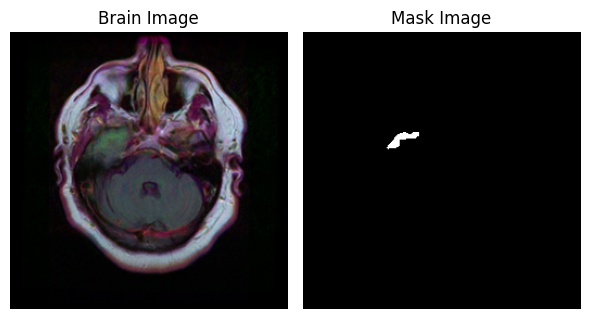

In [7]:
fig, ax = plt.subplots(1,2, figsize=(6,6))

image = cv2.imread('kaggle_3m/' + str(brain_df.image_path[623]))
mask = cv2.imread('kaggle_3m/' + str(brain_df.mask_path[623]))

ax[0].imshow(image)
ax[0].set_title("Brain Image")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title("Mask Image")
ax[1].axis("off")

plt.tight_layout()
plt.show()

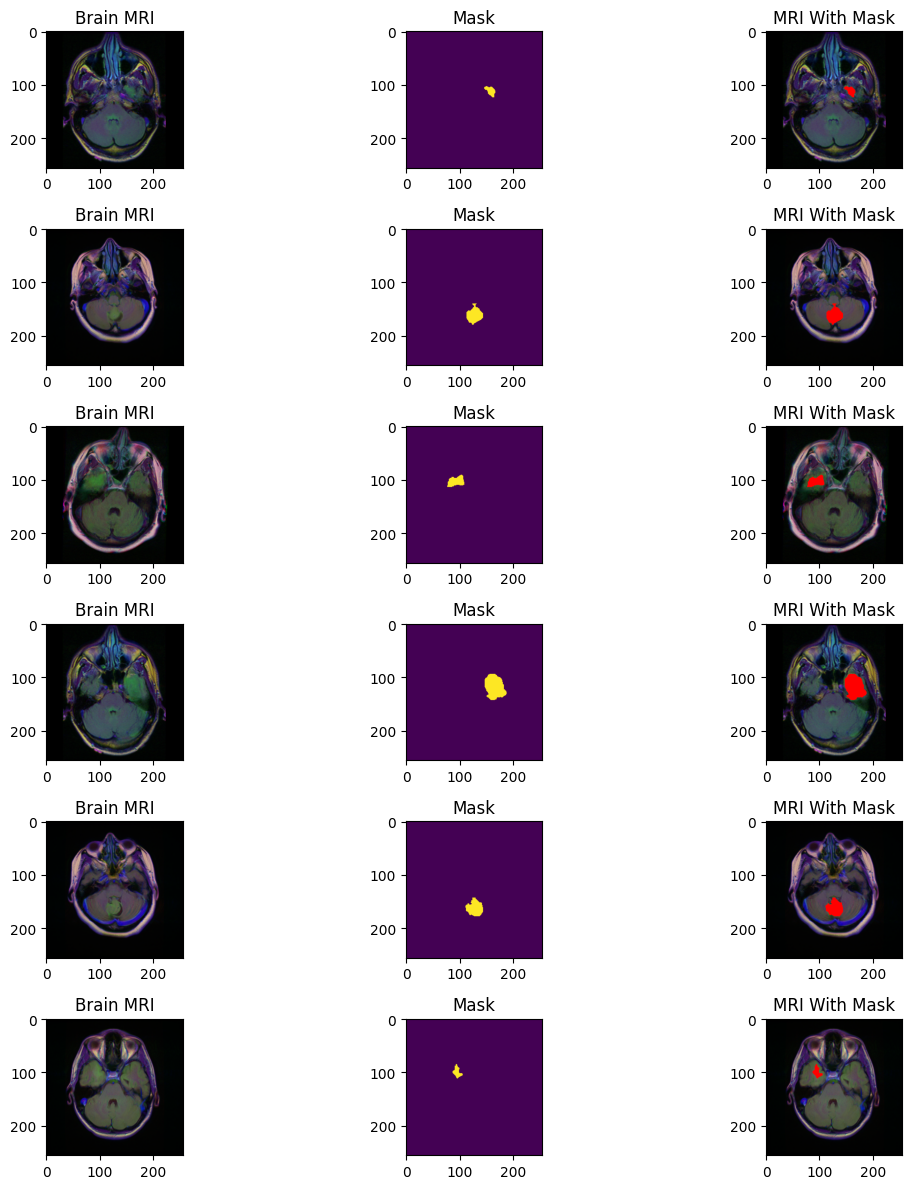

In [8]:
j = 0
fig, axs = plt.subplots(6,3, figsize=(12,12))

for i in range(len(brain_df)):
    if brain_df['mask'][i] == 1 and j < 6:
        
        img = io.imread('kaggle_3m/' + str(brain_df.image_path[i]))
        axs[j][0].title.set_text('Brain MRI')
        axs[j][0].imshow(img)

        mask = io.imread('kaggle_3m/' + str(brain_df.mask_path[i]))
        axs[j][1].title.set_text('Mask')
        axs[j][1].imshow(mask)

        img[mask == 255] = (255, 0, 0)
        axs[j][2].title.set_text('MRI With Mask')
        axs[j][2].imshow(img)

        j += 1

fig.tight_layout()

# U-Net Model

In [9]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [10]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x : str(x))

In [11]:
train, test = train_test_split(brain_df_train, test_size=0.15)

In [12]:
train.shape

(3339, 3)

In [13]:
test.shape

(590, 3)

In [31]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [32]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [55]:
DIR = 'kaggle_3m/'

In [56]:
train_ids = list(DIR + X_train.image_path)
train_mask = list(DIR + X_train.mask_path)

val_ids = list(DIR + X_val.image_path)
val_mask= list(DIR + X_val.mask_path)

In [57]:
from utilities import DataGenerator

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [58]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [59]:
def upsample_concat(x, skip):
    
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [60]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

In [61]:
model = Model(inputs = X_input, outputs = output )

In [62]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_16[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 128, 128,  │          0 │ add_8[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │      2,112 │ max_pooling2d_9[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [83]:
def tversky(y_true, y_pred, smooth=1e-6, alpha=0.5):
    
    y_true = K.cast(y_true, dtype='float32')
    
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)

    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [84]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [85]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath="ResUNet-weights.h5", verbose=1, save_best_only=True)

In [86]:
history = model.fit(training_generator, epochs = 10, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 0.7892 - tversky: 0.2686

/home/predator/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.62513, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 585ms/step - loss: 0.7879 - tversky: 0.2702 - val_loss: 0.6251 - val_tversky: 0.4632
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 0.4729 - tversky: 0.6286
Epoch 2: val_loss improved from 0.62513 to 0.55559, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 480ms/step - loss: 0.4726 - tversky: 0.6290 - val_loss: 0.5556 - val_tversky: 0.5429
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.4025 - tversky: 0.7003
Epoch 3: val_loss improved from 0.55559 to 0.48358, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 424ms/step - loss: 0.4023 - tversky: 0.7006 - val_loss: 0.4836 - val_tversky: 0.6156
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.3536 - tversky: 0.7485
Epoch 4: val_loss improved from 0.48358 to 0.42338, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 411ms/step - loss: 0.3536 - tversky: 0.7485 - val_loss: 0.4234 - val_tversky: 0.6803
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 0.3243 - tversky: 0.7761
Epoch 5: val_loss improved from 0.42338 to 0.37776, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - loss: 0.3242 - tversky: 0.7762 - val_loss: 0.3778 - val_tversky: 0.7230
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.2930 - tversky: 0.8038
Epoch 6: val_loss improved from 0.37776 to 0.34235, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 402ms/step - loss: 0.2930 - tversky: 0.8039 - val_loss: 0.3424 - val_tversky: 0.7597
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - loss: 0.2744 - tversky: 0.8200
Epoch 7: val_loss improved from 0.34235 to 0.27622, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 440ms/step - loss: 0.2743 - tversky: 0.8201 - val_loss: 0.2762 - val_tversky: 0.8185
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.2532 - tversky: 0.8388
Epoch 8: val_loss did not improve from 0.27622
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 344ms/step - loss: 0.2532 - tversky: 0.8388 - val_loss: 0.3283 - val_tversky: 0.7704
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.2449 - tversky: 0.8450
Epoch 9: val_loss improved from 0.27622 to 0.27409, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - loss: 0.2449 - tversky: 0.8450 - val_loss: 0.2741 - val_tversky: 0.8207
Epoch 10/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.2431 - tversky: 0.8469
Epoch 10: val_loss improved from 0.27409 to 0.26721, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 311ms/step - loss: 0.2431 - tversky: 0.8469 - val_loss: 0.2672 - val_tversky: 0.8263


In [87]:
model.save("resunet_brain_segmentation.h5")

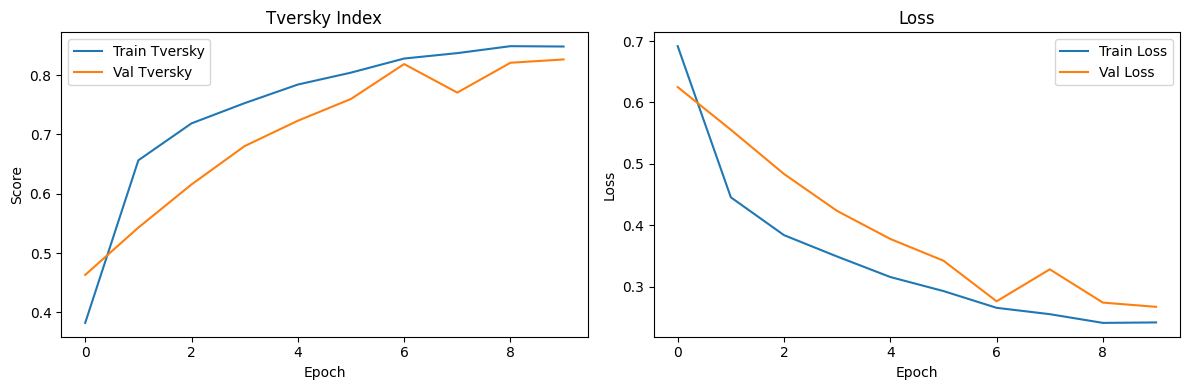

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['tversky'], label='Train Tversky')
plt.plot(history.history['val_tversky'], label='Val Tversky')
plt.title('Tversky Index')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


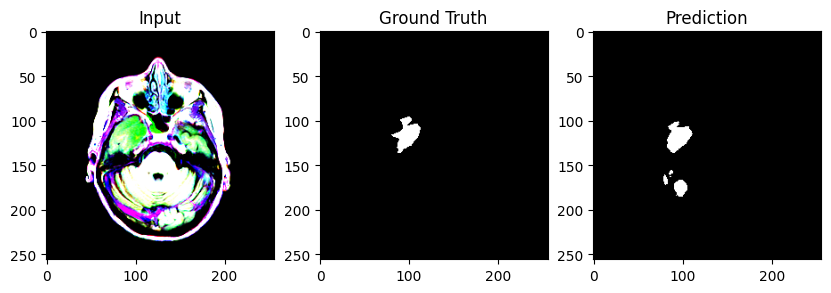

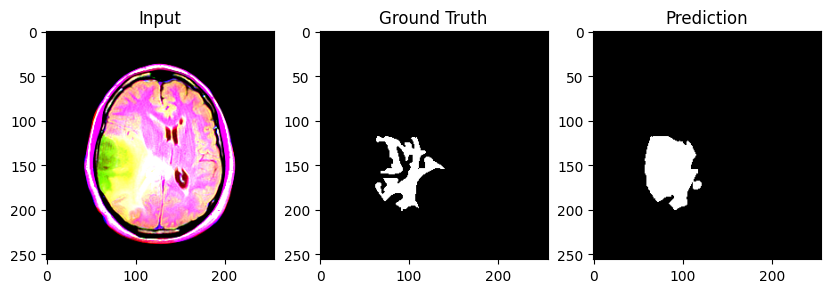

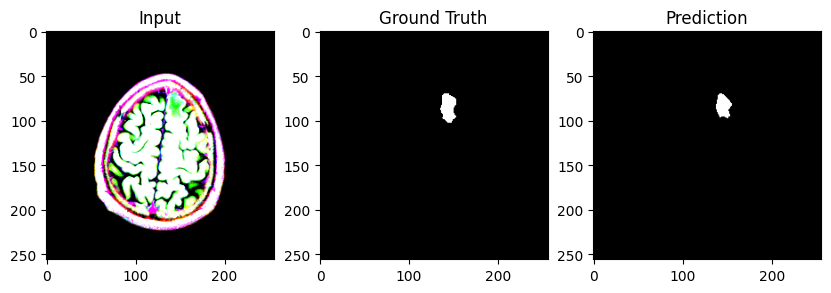

In [90]:
x_test, y_test = validation_generator[0]
preds = model.predict(x_test)

preds_thresh = (preds > 0.5).astype(np.uint8)

for i in range(3):
    plt.figure(figsize=(10,3))

    plt.subplot(1,3,1)
    plt.imshow(x_test[i])
    plt.title("Input")

    plt.subplot(1,3,2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(preds_thresh[i].squeeze(), cmap='gray')
    plt.title("Prediction")

    plt.show()

In [177]:
print("Image dtype:", img.dtype)
print("Image shape:", img.shape)
print("Image has NaNs:", np.isnan(img).any())


Image dtype: float64
Image shape: (256, 256, 3)
Image has NaNs: False
